<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/stock_lstm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt

# 1. Preprocessing

In [42]:
def make_multistep_dataset(df, features_column, steps=1):
  
  for i in range(steps):
    for feature in features_column:
      df[feature+"(t-"+str(i+1)+")"] = df[feature+"(t)"].shift(i+1)
  
  df = df.dropna()
  return df


def preprocess(df):

  #dropna
  df = df.dropna()
  #normalize
  scaler = MinMaxScaler(feature_range=(0, 1))
  df[df.columns] = scaler.fit_transform(df[df.columns])
  return df

def get_file_index(file_name):

    index = file_name.split(".")[0]
    start = 0
    while (start < len(index) and index[start] == "0"):
      start += 1
    return int(index[start:])


def load_single_stock_data(path, columns, steps):

  df = pd.read_csv(path, names=columns)
  df = preprocess(df)
  
  features_column = [x[:-3] for x in columns]
  df = make_multistep_dataset(df, features_column, steps)
  df = df.dropna()
  df['time_index'] = df.index
  df = df.reset_index(drop = True)

  return df



def load_data(data_folder, n_stocks, columns, steps):

  files = os.listdir(data_folder)
  files.sort(key = lambda x: get_file_index(x))

  df = None
  for i in range(n_stocks):
    
    # get file name
    file = files[i]

    # load data
    df_temp = pd.read_csv(data_folder+"/"+file, names=columns)

    # preprocess data
    df_temp = preprocess(df_temp)

    # make multistep dataset
    features_column = [x[:-3] for x in columns]
    df_temp = make_multistep_dataset(df_temp, features_column, steps)
    df_temp = df_temp.dropna()
    df_temp['time_index'] = df_temp.index #keep the original timestep index of each record

    #concatenate with df
    if (i==0):
      df = df_temp
    else:
      df = pd.concat([df, df_temp])

    # make sure the index is correct
    df = df.reset_index(drop = True)
  
  return df


In [8]:
def prepare_train_data(df, features_column, target_column, steps, start=0, train_window=72):
  '''
  'features_column' here is not necessarily the same as 'features_column' in make_multistep_dataset() and is a list
  'target_column' is a string, e.g. "open"
  '''

  df = df.loc[(df.time_index >= start) & (df.time_index < start+train_window)]

  train_columns = []
  for i in range(1, steps+1):
      train_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  X_train = df[train_columns].values
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], steps, len(features_column))) #lstm data shape: (samples, timesteps, features)
  y_train = df[target_column+"(t)"].values

  print(X_train.shape, X_train_lstm.shape, y_train.shape)
  return (X_train, X_train_lstm, y_train)



def prepare_trade_data(df, features_column, target_column, steps, time_index):

  df = df.loc[df.time_index == time_index]

  columns = []
  for i in range(1, steps+1):
      columns.extend([x+"(t-"+str(i)+")" for x in features_column])
 
  X_trade = df[columns].values
  X_trade_lstm = np.reshape(X_trade, (X_trade.shape[0], steps, len(features_column)))
  y_trade = df[target_column+"(t)"].values

  print(X_trade.shape, X_trade_lstm.shape, y_trade.shape)
  return (X_trade, X_trade_lstm, y_trade)


# 2. LSTM Models

In [36]:
# models, two lstm models
def train_lstm1(X_train, y_train, epochs=50, batch_size=48):

  model = Sequential()
  model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  # fit network
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

  return model


def train_lstm2(X_train, y_train, epochs=50, batch_size=48):

  model = Sequential()
  model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(20))
  model.add(Dense(10))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

  return model


# 3. LSTM Training (single stock)
using the data from a single stock to predict the stock price (close price) for the same stock. 

In [10]:
# prepare data

path = "/content/drive/MyDrive/StockML /processed_data/000001.XSHE.csv"
columns = ["open(t)", "close(t)", "high(t)", "low(t)"]
steps = 3
df = load_single_stock_data(path, columns, steps)
display(df)

#data_folder = "/content/drive/MyDrive/StockML /processed_data"
#n_stocks = 1
#df = load_data(data_folder, n_stocks, columns, steps)
#display(df)


,open(t),close(t),high(t),low(t),open(t-1),close(t-1),high(t-1),low(t-1),open(t-2),close(t-2),high(t-2),low(t-2),open(t-3),close(t-3),high(t-3),low(t-3),time_index
0,0.686141,0.675307,0.702479,0.693460,0.623641,0.712142,0.742424,0.675749,0.622283,0.616644,0.721763,0.674387,0.543478,0.631651,0.622590,0.555858,3
1,0.690217,0.713506,0.752066,0.728883,0.686141,0.675307,0.702479,0.693460,0.623641,0.712142,0.742424,0.675749,0.622283,0.616644,0.721763,0.674387,4
2,0.716033,0.911323,0.950413,0.727520,0.690217,0.713506,0.752066,0.728883,0.686141,0.675307,0.702479,0.693460,0.623641,0.712142,0.742424,0.675749,5
3,0.767663,0.739427,0.827824,0.756131,0.716033,0.911323,0.950413,0.727520,0.690217,0.713506,0.752066,0.728883,0.686141,0.675307,0.702479,0.693460,6
4,0.781250,0.965894,0.975207,0.820163,0.767663,0.739427,0.827824,0.756131,0.716033,0.911323,0.950413,0.727520,0.690217,0.713506,0.752066,0.728883,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.012228,0.045020,0.033058,0.000000,0.050272,0.001364,0.020661,0.008174,0.048913,0.038199,0.046832,0.081744,0.040761,0.009550,0.023416,0.068120,125
123,0.059783,0.028649,0.034435,0.065395,0.012228,0.045020,0.033058,0.000000,0.050272,0.001364,0.020661,0.008174,0.048913,0.038199,0.046832,0.081744,126
124,0.066576,0.017735,0.023416,0.057221,0.059783,0.028649,0.034435,0.065395,0.012228,0.045020,0.033058,0.000000,0.050272,0.001364,0.020661,0.008174,127
125,0.020380,0.000000,0.020661,0.054496,0.066576,0.017735,0.023416,0.057221,0.059783,0.028649,0.034435,0.065395,0.012228,0.045020,0.033058,0.000000,128


(72, 12) (72, 3, 4) (72,)
(48, 12) (48, 3, 4) (48,)
Epoch 1/50
2/2 - 18s - loss: 0.4425
Epoch 2/50
2/2 - 0s - loss: 0.3812
Epoch 3/50
2/2 - 0s - loss: 0.3194
Epoch 4/50
2/2 - 0s - loss: 0.2568
Epoch 5/50
2/2 - 0s - loss: 0.1948
Epoch 6/50
2/2 - 0s - loss: 0.1387
Epoch 7/50
2/2 - 0s - loss: 0.0967
Epoch 8/50
2/2 - 0s - loss: 0.0779
Epoch 9/50
2/2 - 0s - loss: 0.0926
Epoch 10/50
2/2 - 0s - loss: 0.1133
Epoch 11/50
2/2 - 0s - loss: 0.1221
Epoch 12/50
2/2 - 0s - loss: 0.1174
Epoch 13/50
2/2 - 0s - loss: 0.1049
Epoch 14/50
2/2 - 0s - loss: 0.0913
Epoch 15/50
2/2 - 0s - loss: 0.0832
Epoch 16/50
2/2 - 0s - loss: 0.0824
Epoch 17/50
2/2 - 0s - loss: 0.0847
Epoch 18/50
2/2 - 0s - loss: 0.0854
Epoch 19/50
2/2 - 0s - loss: 0.0849
Epoch 20/50
2/2 - 0s - loss: 0.0834
Epoch 21/50
2/2 - 0s - loss: 0.0809
Epoch 22/50
2/2 - 0s - loss: 0.0795
Epoch 23/50
2/2 - 0s - loss: 0.0799
Epoch 24/50
2/2 - 0s - loss: 0.0821
Epoch 25/50
2/2 - 0s - loss: 0.0834
Epoch 26/50
2/2 - 0s - loss: 0.0830
Epoch 27/50
2/2 - 0s

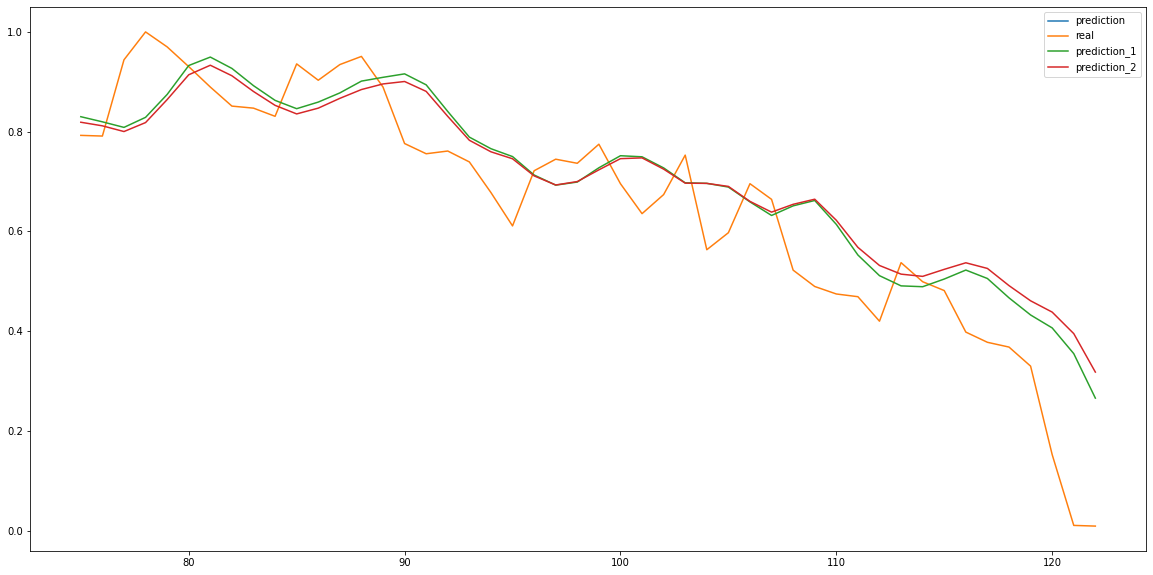

In [11]:
# training set up 
features_column = ["open", "close", "high", "low"]
target_column = "close"
steps = 3
train_start = steps
train_window = 72
test_start = train_start + train_window
test_window = 48

# prepare datasets
X_train, X_train_lstm, y_train = prepare_train_data(df, features_column, target_column, steps, train_start, train_window)
X_test, X_test_lstm, y_test = prepare_train_data(df, features_column, target_column, steps, test_start, test_window)

# train and predict
model_1 = train_lstm1(X_train_lstm, y_train)
y_pred_1 = model_1.predict(X_test_lstm)
model_2 = train_lstm2(X_train_lstm, y_train)
y_pred_2 = model_2.predict(X_test_lstm)

df_predictions = pd.DataFrame(index=list(range(test_start, test_start+test_window)), columns=["prediction", "real"])
df_predictions["prediction_1"] = y_pred_1
df_predictions["prediction_2"] = y_pred_2
df_predictions["real"] = y_test
df_predictions.plot(figsize=(20,10))
plt.show()



# 4. LSTM Training (multiple stocks)

In [43]:
# prepare data
columns = ["open(t)", "close(t)", "high(t)", "low(t)"]
steps = 50
data_folder = "/content/drive/MyDrive/StockML /processed_data"
n_stocks = 100 # use 100 stocks
df = load_data(data_folder, n_stocks, columns, steps)
display(df)

,open(t),close(t),high(t),low(t),open(t-1),close(t-1),high(t-1),low(t-1),open(t-2),close(t-2),high(t-2),low(t-2),open(t-3),close(t-3),high(t-3),low(t-3),open(t-4),close(t-4),high(t-4),low(t-4),open(t-5),close(t-5),high(t-5),low(t-5),open(t-6),close(t-6),high(t-6),low(t-6),open(t-7),close(t-7),high(t-7),low(t-7),open(t-8),close(t-8),high(t-8),low(t-8),open(t-9),close(t-9),high(t-9),low(t-9),...,close(t-41),high(t-41),low(t-41),open(t-42),close(t-42),high(t-42),low(t-42),open(t-43),close(t-43),high(t-43),low(t-43),open(t-44),close(t-44),high(t-44),low(t-44),open(t-45),close(t-45),high(t-45),low(t-45),open(t-46),close(t-46),high(t-46),low(t-46),open(t-47),close(t-47),high(t-47),low(t-47),open(t-48),close(t-48),high(t-48),low(t-48),open(t-49),close(t-49),high(t-49),low(t-49),open(t-50),close(t-50),high(t-50),low(t-50),time_index
0,4.089674,4.010914,3.884298,4.427793,5.149457,3.901774,4.738292,4.482289,5.421196,4.706685,5.027548,5.095368,5.081522,5.061392,5.041322,5.422343,5.652174,5.170532,5.316804,5.395095,5.203804,5.225102,5.537190,5.667575,5.407609,4.979536,5.041322,5.463215,5.923913,5.361528,5.564738,5.653951,5.502717,5.675307,5.509642,5.790191,4.972826,5.566166,5.316804,5.258856,...,9.631651,9.931129,9.400545,8.750000,9.181446,9.834711,9.087193,7.812500,9.658936,9.752066,8.201635,7.676630,7.394270,8.278237,7.561308,7.160326,9.113233,9.504132,7.275204,6.902174,7.135061,7.520661,7.288828,6.861413,6.753070,7.024793,6.934605,6.236413,7.121419,7.424242,6.757493,6.222826,6.166439,7.217631,6.743869,5.434783,6.316508,6.225895,5.558583,50
1,4.184783,3.860846,3.966942,4.196185,4.089674,4.010914,3.884298,4.427793,5.149457,3.901774,4.738292,4.482289,5.421196,4.706685,5.027548,5.095368,5.081522,5.061392,5.041322,5.422343,5.652174,5.170532,5.316804,5.395095,5.203804,5.225102,5.537190,5.667575,5.407609,4.979536,5.041322,5.463215,5.923913,5.361528,5.564738,5.653951,5.502717,5.675307,5.509642,5.790191,...,9.454297,9.380165,9.168937,9.320652,9.631651,9.931129,9.400545,8.750000,9.181446,9.834711,9.087193,7.812500,9.658936,9.752066,8.201635,7.676630,7.394270,8.278237,7.561308,7.160326,9.113233,9.504132,7.275204,6.902174,7.135061,7.520661,7.288828,6.861413,6.753070,7.024793,6.934605,6.236413,7.121419,7.424242,6.757493,6.222826,6.166439,7.217631,6.743869,51
2,4.144022,3.437926,3.732782,3.732970,4.184783,3.860846,3.966942,4.196185,4.089674,4.010914,3.884298,4.427793,5.149457,3.901774,4.738292,4.482289,5.421196,4.706685,5.027548,5.095368,5.081522,5.061392,5.041322,5.422343,5.652174,5.170532,5.316804,5.395095,5.203804,5.225102,5.537190,5.667575,5.407609,4.979536,5.041322,5.463215,5.923913,5.361528,5.564738,5.653951,...,9.154161,9.297521,9.264305,9.728261,9.454297,9.380165,9.168937,9.320652,9.631651,9.931129,9.400545,8.750000,9.181446,9.834711,9.087193,7.812500,9.658936,9.752066,8.201635,7.676630,7.394270,8.278237,7.561308,7.160326,9.113233,9.504132,7.275204,6.902174,7.135061,7.520661,7.288828,6.861413,6.753070,7.024793,6.934605,6.236413,7.121419,7.424242,6.757493,52
3,3.600543,3.301501,3.264463,3.378747,4.144022,3.437926,3.732782,3.732970,4.184783,3.860846,3.966942,4.196185,4.089674,4.010914,3.884298,4.427793,5.149457,3.901774,4.738292,4.482289,5.421196,4.706685,5.027548,5.095368,5.081522,5.061392,5.041322,5.422343,5.652174,5.170532,5.316804,5.395095,5.203804,5.225102,5.537190,5.667575,5.407609,4.979536,5.041322,5.463215,...,8.117326,9.462810,8.201635,9.578804,9.154161,9.297521,9.264305,9.728261,9.454297,9.380165,9.168937,9.320652,9.631651,9.931129,9.400545,8.750000,9.181446,9.834711,9.087193,7.812500,9.658936,9.752066,8.201635,7.676630,7.394270,8.278237,7.561308,7.160326,9.113233,9.504132,7.275204,6.902174,7.135061,7.520661,7.288828,6.861413,6.753070,7.024793,6.934605,53
4,3.152174,4.502046,4.366391,3.501362,3.600543,3.301501,3.264463,3.378747,4.144022,3.437926,3.732782,3.732970,4.184783,3.860846,3.966942,4.196185,4.089674,4.010914,3.884298,4.427793,5.149457,3.901774,4.738292,4.482289,5.421196,4.706685,5.027548,5.095368,5.081522,5.061392,5.041322,5.

In [44]:
# training set up 
features_column = ["open", "close", "high", "low"]
target_column = "close"
steps = 10 #use 10 timesteps for each training sample
train_start = steps
train_window = 72
test_start = train_start + train_window
test_window = 32
epochs = 100

# prepare datasets
X_train, X_train_lstm, y_train = prepare_train_data(df, features_column, target_column, steps, train_start, train_window)
X_test, X_test_lstm, y_test = prepare_train_data(df, features_column, target_column, steps, test_start, test_window)

# train and predict
model_1 = train_lstm1(X_train_lstm, y_train, epochs)
y_pred_1 = model_1.predict(X_test_lstm)
y_pred_1 = np.reshape(y_pred_1, (-1, test_window)) #reshape into (n_stocks, test_window)
model_2 = train_lstm2(X_train_lstm, y_train, epochs)
y_pred_2 = model_2.predict(X_test_lstm)
y_pred_2 = np.reshape(y_pred_2, (-1, test_window)) #reshape into (n_stocks, test_window)
y_test = np.reshape(y_test, (-1, test_window))

(3200, 40) (3200, 10, 4) (3200,)
(3200, 40) (3200, 10, 4) (3200,)
Epoch 1/100
67/67 - 2s - loss: 2.0576
Epoch 2/100
67/67 - 0s - loss: 1.1530
Epoch 3/100
67/67 - 0s - loss: 0.9675
Epoch 4/100
67/67 - 0s - loss: 0.8651
Epoch 5/100
67/67 - 0s - loss: 0.7471
Epoch 6/100
67/67 - 0s - loss: 0.6593
Epoch 7/100
67/67 - 0s - loss: 0.6048
Epoch 8/100
67/67 - 0s - loss: 0.5735
Epoch 9/100
67/67 - 0s - loss: 0.5546
Epoch 10/100
67/67 - 0s - loss: 0.5355
Epoch 11/100
67/67 - 0s - loss: 0.5249
Epoch 12/100
67/67 - 0s - loss: 0.5188
Epoch 13/100
67/67 - 0s - loss: 0.4989
Epoch 14/100
67/67 - 0s - loss: 0.4936
Epoch 15/100
67/67 - 0s - loss: 0.4885
Epoch 16/100
67/67 - 0s - loss: 0.4923
Epoch 17/100
67/67 - 0s - loss: 0.5013
Epoch 18/100
67/67 - 0s - loss: 0.4860
Epoch 19/100
67/67 - 0s - loss: 0.4879
Epoch 20/100
67/67 - 0s - loss: 0.4790
Epoch 21/100
67/67 - 0s - loss: 0.4893
Epoch 22/100
67/67 - 0s - loss: 0.4769
Epoch 23/100
67/67 - 0s - loss: 0.4717
Epoch 24/100
67/67 - 0s - loss: 0.4772
Epoch 2

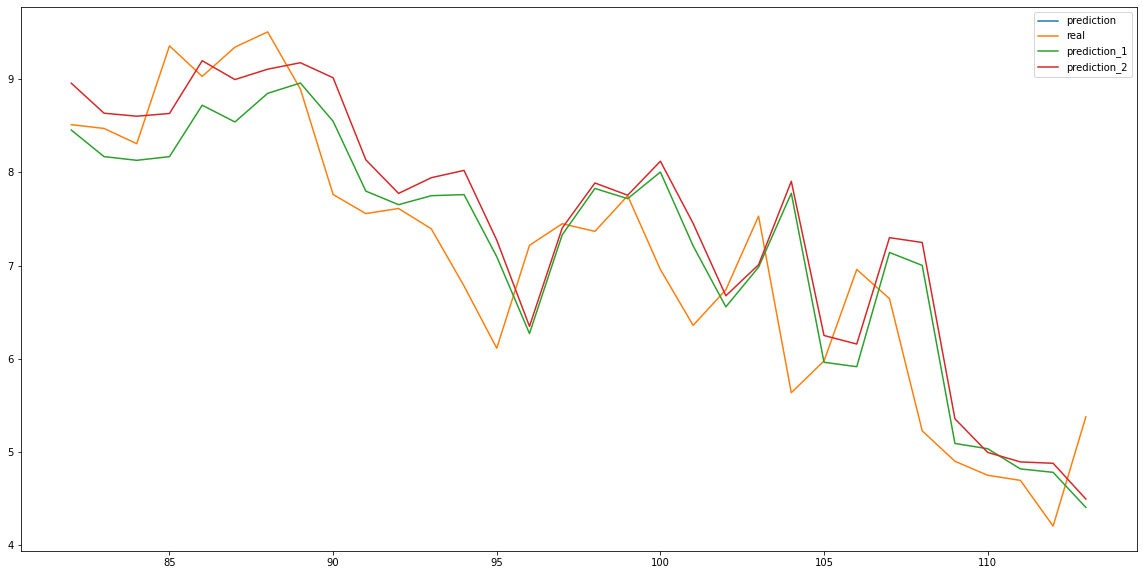

In [45]:
df_predictions = pd.DataFrame(index=list(range(test_start, test_start+test_window)), columns=["prediction", "real"])
df_predictions["prediction_1"] = y_pred_1[0]
df_predictions["prediction_2"] = y_pred_2[0]
df_predictions["real"] = y_test[0]
df_predictions.plot(figsize=(20,10))
plt.show()